In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import kagglehub
import os
import torch.nn as nn
import torchvision.models as models
import wandb
import gc
from torchinfo import summary
from torch import optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import warnings
warnings.filterwarnings("ignore")

c:\Users\panda\OneDrive\Documents\Coding_Stuff\Computer Vision\venv_py311_cuda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I did not implemented wandb here because I do not want to 😂😜😜

# Dataset_Preparation and Sampling

In [3]:
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

# Hyperparameters
batch_size = 16
learning_rate = 0.001
num_epochs = 15
image_size = 224
hidden_nodes = 128

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset_path = os.path.join(path, "flowers")
dataset = ImageFolder(root=dataset_path, transform=transform)

In [4]:
train_data, test_data, val_data = random_split(dataset, [0.8, 0.1, 0.1])
train_dataset = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_dataset = DataLoader(val_data, batch_size=batch_size, shuffle=True)

# Training start

In [5]:
summary(models.mobilenet_v2())

Layer (type:depth-idx)                             Param #
MobileNetV2                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─ReLU6: 3-3                             --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        896
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        5,136
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        8,832
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,000
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        14,848
│    └─InvertedResidual: 2-7                       --
│    │ 

In [6]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights)
        # Change the final conv layer to match 5 flower dataset
        self.base_model.classifier[1] = nn.Linear(in_features=1280, out_features=5)
        # Freeze the feature layers
        for param in self.base_model.parameters():
            param.requires_grad = False
        # Unsqeeze the final layer only 
        for param in self.base_model.classifier[1].parameters():
            param.requires_grad = True
    def forward(self, x):
        x = self.base_model(x)
        return x

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MobileNet().to(device)
summary(model)  # Great way to look overall what is happening inside your model

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\panda/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:01<00:00, 11.8MB/s]


Layer (type:depth-idx)                                  Param #
MobileNet                                               --
├─MobileNetV2: 1-1                                      --
│    └─Sequential: 2-1                                  --
│    │    └─Conv2dNormActivation: 3-1                   (928)
│    │    └─InvertedResidual: 3-2                       (896)
│    │    └─InvertedResidual: 3-3                       (5,136)
│    │    └─InvertedResidual: 3-4                       (8,832)
│    │    └─InvertedResidual: 3-5                       (10,000)
│    │    └─InvertedResidual: 3-6                       (14,848)
│    │    └─InvertedResidual: 3-7                       (14,848)
│    │    └─InvertedResidual: 3-8                       (21,056)
│    │    └─InvertedResidual: 3-9                       (54,272)
│    │    └─InvertedResidual: 3-10                      (54,272)
│    │    └─InvertedResidual: 3-11                      (54,272)
│    │    └─InvertedResidual: 3-12                  

## Correct and optimised training loop

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_values = []
training_accuracy = []
validation_accuracy = []
# Training loop
for epoch in range(num_epochs):
    # --- TRAINING PHASE ---
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_dataset:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    avg_loss = running_loss / len(train_dataset)
    train_acc = correct_train / total_train
    
    loss_values.append(avg_loss)
    training_accuracy.append(train_acc)
    
    # --- VALIDATION PHASE ---
    model.eval()
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_dataset:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    val_acc = correct_val / total_val
    validation_accuracy.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch [1/15] | Loss: 0.6628 | Train Acc: 0.7739 | Val Acc: 0.8770
Epoch [2/15] | Loss: 0.4139 | Train Acc: 0.8547 | Val Acc: 0.8608
Epoch [3/15] | Loss: 0.3823 | Train Acc: 0.8619 | Val Acc: 0.8933
Epoch [4/15] | Loss: 0.3559 | Train Acc: 0.8749 | Val Acc: 0.8747
Epoch [5/15] | Loss: 0.3647 | Train Acc: 0.8674 | Val Acc: 0.8979
Epoch [6/15] | Loss: 0.3335 | Train Acc: 0.8801 | Val Acc: 0.9026
Epoch [7/15] | Loss: 0.3206 | Train Acc: 0.8816 | Val Acc: 0.9049
Epoch [8/15] | Loss: 0.3153 | Train Acc: 0.8923 | Val Acc: 0.9026
Epoch [9/15] | Loss: 0.3077 | Train Acc: 0.8926 | Val Acc: 0.8863
Epoch [10/15] | Loss: 0.3188 | Train Acc: 0.8848 | Val Acc: 0.8956
Epoch [11/15] | Loss: 0.3197 | Train Acc: 0.8813 | Val Acc: 0.8863
Epoch [12/15] | Loss: 0.3133 | Train Acc: 0.8906 | Val Acc: 0.8886
Epoch [13/15] | Loss: 0.2986 | Train Acc: 0.8897 | Val Acc: 0.8910
Epoch [14/15] | Loss: 0.2910 | Train Acc: 0.8975 | Val Acc: 0.8933
Epoch [15/15] | Loss: 0.2980 | Train Acc: 0.8914 | Val Acc: 0.8910


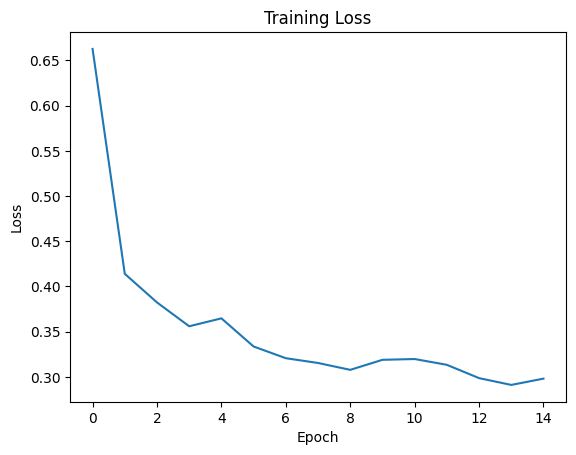

In [10]:
plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

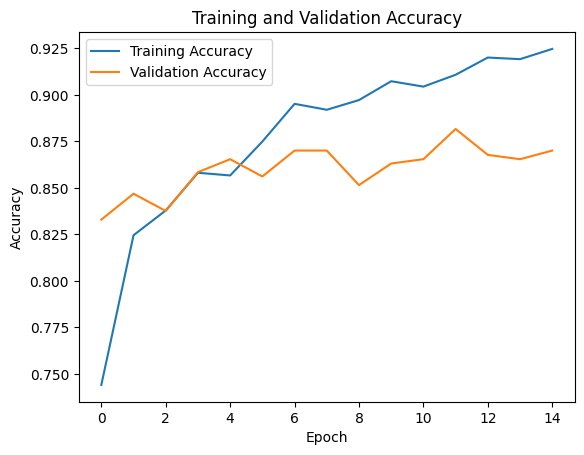

In [17]:
plt.plot(training_accuracy, label="Training Accuracy")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Test

In [11]:
model.eval()
correct_test = 0
total_test = 0
with torch.no_grad():
  for images, labels in test_dataset:
    images, labels = images.to(device), labels.to(device)
    y_eval = model(images)
    _, predicted = torch.max(y_eval, 1)
    correct_test += (predicted==labels).sum().item()  # .item() converts tensor value to single value scalar
    total_test += len(labels)
  test_accuracy = correct_test/total_test

print(f"Overall test Accuracy: {test_accuracy:.4f}")
print(f"Final train Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final validation Accuracy: {validation_accuracy[-1]:.4f}")

Overall test Accuracy: 0.8843
Final train Accuracy: 0.8914
Final validation Accuracy: 0.8910


Despite its compact and lightweight architecture, MobileNet delivers strong performance after fine-tuning. Compared to a basic deep neural network, fine-tuned MobileNet achieves a clear improvement in both training and validation accuracy, demonstrating its efficiency in learning meaningful features.

The close alignment between training, validation, and test accuracies indicates good generalization with minimal overfitting. These results highlight MobileNet’s key advantage: high accuracy with a small model size. By leveraging pretrained features and fine-tuning them for the target task, MobileNet achieves excellent performance without the computational cost of training a large network from scratch, making it well suited for mobile and resource-constrained environments.